In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/masters

In [ ]:
%ls ./data/processed

# T1H-X1700M-Y1760M/  T24H-X850M-Y880M/  T3H-X850M-Y880M/
# T12H-X850M-Y880M/  T24H-X425M-Y440M/   T24H-X85M-Y110M/   T6H-X850M-Y880M/

In [ ]:
# to test indexing of loaders
# have model that does nothing and make input and targets equal should show if there are any discrepancies

In [2]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork, SmallKangFNN
from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from utils.utils import pshape
from trainers.generic_trainer import train_model
from models.kangkang_fnn_models import train_epoch_for_fnn

In [3]:
start_date = "2013-01-01"
end_date = "2015-01-01" 

data_dim_str = "T24H-X850M-Y880M"  #"T1H-X1700M-Y1760M"  # needs to exist
model_name = "FNN-CRIME-MODEL"  # needs to be created
data_path = f"./data/processed/{data_dim_str}_{start_date}_{end_date}/"

if not os.path.exists(data_path):
    raise Exception(f"Directory ({data_path}) needs to exist.")

model_path = data_path + f"models/{model_name}/"
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

timer = Timer()
# manually set the config
# manually set the config
conf_dict = {
    "seed": 3,
    "use_cuda": False,
    
    "use_crime_types": False,
    
    # data group/data set related
    "val_ratio": 0.1,  # ratio of the total dataset
    "tst_ratio": 0.2,# ratio of the total dataset
    "seq_len": 1,
    "flatten_grid": True,  # if the shaper should be used to squeeze the data
    
    # shaper related 
    "shaper_top_k": -1,  # if less then 0, top_k will not be applied
    "shaper_threshold": 0,

    
    # data loader related
    "sub_sample_train_set": True,
    "sub_sample_validation_set": True,
    "sub_sample_test_set": False,
    
    # training parameters
    "resume": False,
    "early_stopping": False,
    "tolerance": 1e-8,
    "lr": 1e-3,
    "weight_decay": 1e-8,
    "max_epochs": 1,
    "batch_size": 64,
    "dropout": 0.2,
    "shuffle": False,
    "num_workers": 6,
    
    # attached global variables - bad practice -find alternative
    "device": None,  # pytorch device object [CPU|GPU]
    "timer": Timer(),
    "model_name": model_name,
    "model_path": model_path,
    "checkpoint": "best",
    
    "use_seq_loss": True,
}
conf = BaseConf(conf_dict=conf_dict)

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed( conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

2019-10-27T21:56:22 | root | INFO | =====================================BEGIN=====================================
2019-10-27T21:56:22 | root | INFO | Device: cpu


In [4]:
log.getLogger().setLevel("WARNING")

In [5]:
log.getLogger().setLevel("INFO")

2019-10-27T22:30:46 | root | INFO | Data shapes of files in generated_data.npz
2019-10-27T22:30:46 | root | INFO | 	crime_feature_indices shape (10,)
2019-10-27T22:30:47 | root | INFO | 	crime_types_grids shape (730, 10, 47, 33)
2019-10-27T22:30:47 | root | INFO | 	crime_grids shape (730, 1, 47, 33)
2019-10-27T22:30:47 | root | INFO | 	tract_count_grids shape (730, 1, 47, 33)
2019-10-27T22:30:47 | root | INFO | 	demog_grid shape (1, 37, 47, 33)
2019-10-27T22:30:47 | root | INFO | 	street_grid shape (1, 512, 47, 33)
2019-10-27T22:30:47 | root | INFO | 	time_vectors shape (731, 52)
2019-10-27T22:30:47 | root | INFO | 	weather_vectors shape (365, 11)
2019-10-27T22:30:47 | root | INFO | 	x_range shape (33,)
2019-10-27T22:30:47 | root | INFO | 	y_range shape (47,)
2019-10-27T22:30:47 | root | INFO | 	t_range shape (731,)
2019-10-27T22:30:47 | root | INFO | Start Training FNN-CRIME-MODEL
2019-10-27T22:30:47 | root | INFO | Using optimiser: 
Adam (
Parameter Group 0
    amsgrad: False
    bet

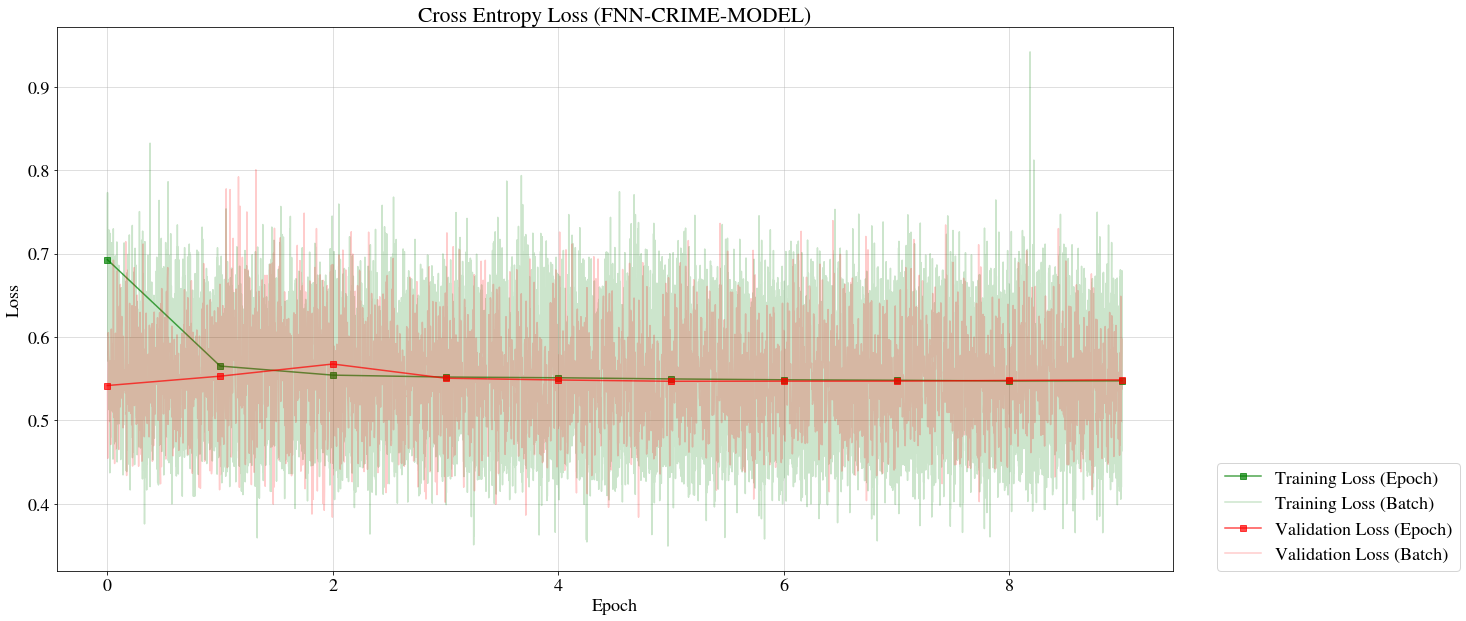

In [20]:
# SET THE HYPER PARAMETERS
conf.early_stopping = False
conf.max_epochs = 4
conf.dropout = 0 #1e-3
conf.weight_decay = 0
conf.resume = True
conf.checkpoint = "best" # ["best"|"latest"]
conf.lr = 1e-2
conf.shaper_top_k = -1

MOCK = False

if MOCK:
    # MOCK THE DATA
    vector_size= [5,5,5]#[37,65,512]
    batch_size = 100    
    class_split=0.5
    train_loader = MockLoader(vector_size, conf.batch_size, n_samples=1000, class_split=class_split)
    validation_loader = MockLoader(vector_size, conf.batch_size, n_samples=200, class_split=class_split)
    test_loader = MockLoader(vector_size, conf.batch_size, n_samples=300, class_split=class_split)
    loaders = MockLoaders(train_loader,validation_loader,test_loader)
else:
    # CRIME DATA
    data_group = FlatDataGroup(data_path=data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)

conf.freqstr = data_group.t_range.freqstr    

# SET LOSS FUNCTION
# size averaged - so more epochs or larger lr for smaller batches
loss_function = nn.CrossEntropyLoss()  

# SETUP MODEL
train_set = loaders.train_loader.dataset
indices, spc_feats, tmp_feats, env_feats, target = train_set[train_set.min_index]
spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]


model_arch = {
    "h_size0": 100,
    "h_size1": 100,
    "h_size2": 100,
}
model = SmallKangFNN(spc_size=spc_size,
                     tmp_size=tmp_size,
                     env_size=env_size,
                     dropout_p=conf.dropout,
                     model_arch=model_arch)

# model_arch = {
#     "scp_net_h0": 64,
#     "scp_net_h1": 32,
#     "tmp_net_h0": 64,
#     "tmp_net_h1": 32,
#     "env_net_h0": 64,
#     "env_net_h1": 32,
#     "final_net_h1": 64,
# }
# model = KangFeedForwardNetwork(spc_size=spc_size,
#                                  tmp_size=tmp_size,
#                                  env_size=env_size,
#                                  dropout_p=conf.dropout,
#                                  model_arch=model_arch)

model.to(conf.device)

# SETUP OPTIMISER
parameters = model.parameters()

# important note: using weight decay (l2 penalty) can prohibit long term memory in LSTM networks
# - use gradient clipping instead
optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

##### RESUME LOGIC
if conf.resume:  # todo check if the files actually exist
    try:
        # resume from previous check point or resume from best validaton score checkpoint
        # load model state
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                      map_location=conf.device.type)
        model.load_state_dict(model_state_dict)
        
        # load optimiser state
        optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                          map_location=conf.device.type)
        optimiser.load_state_dict(optimiser_state_dict) 

        # new optimiser hyper-parameters
        optimiser.param_groups[0]['lr'] = conf.lr
        optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

        # new model hyper-parameters
        model.dropout.p = conf.dropout # note that drop out is not part of the saved state dict

    except Exception as e:
        log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

best_val_loss, stopped_early = train_model(model=model,
                                            optimiser=optimiser,
                                            loaders=loaders,
                                            train_epoch_fn=train_epoch_for_fnn,
                                            loss_fn=loss_function,
                                            conf=conf)    

print(f"best_val_loss: {best_val_loss}, stopped_early: {stopped_early}") # use the current epoch instead
# if stopped_early -> continue with best_model - new hyper-parameters -> no n 

In [ ]:
log.getLogger().setLevel("INFO")

# Evaluation

2019-10-27T22:30:28 | root | INFO | f1_score: 0.6771394744747398 at index 10053, new threshold 0.37644505500793457
2019-10-27T22:30:29 | root | INFO | 
        MODEL METRICS
            Model Name: FNN-CRIME-MODEL
                ROC AUC:            0.7852150572404402
                Average Precision:  0.7063414721226193
                Accuracy:           0.6704365079365079
                MCC:                0.4047578182749967          
        
2019-10-27T22:30:29 | root | INFO | 
        MODEL RESULT
            Model Name: FNN-CRIME-MODEL
                ROC AUC:            0.7852150572404402
                Average Precision:  0.7063414721226193
                Accuracy:           0.6704365079365079
                MCC:                0.4047578182749967          
        
setup - done


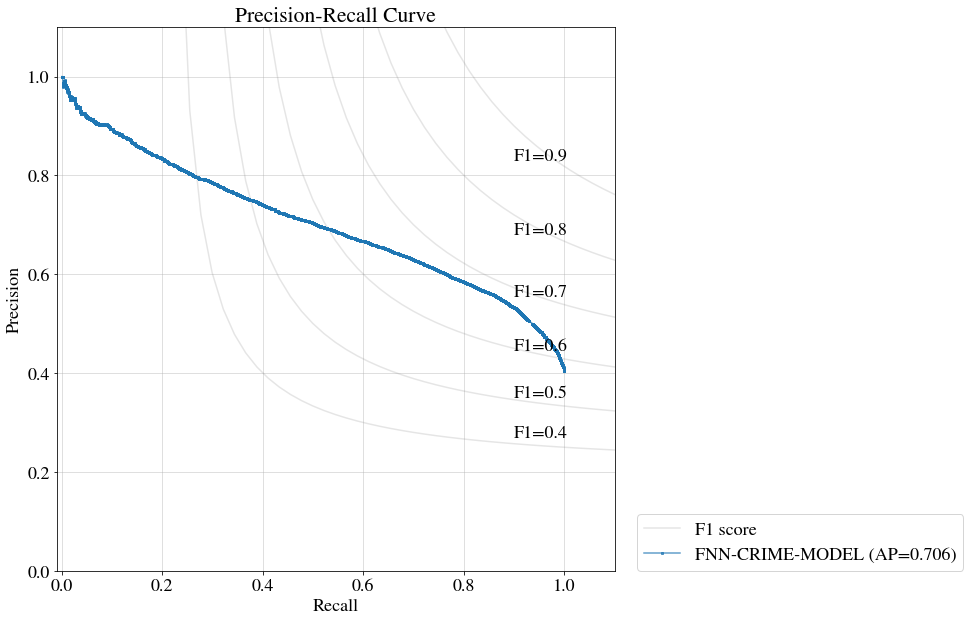

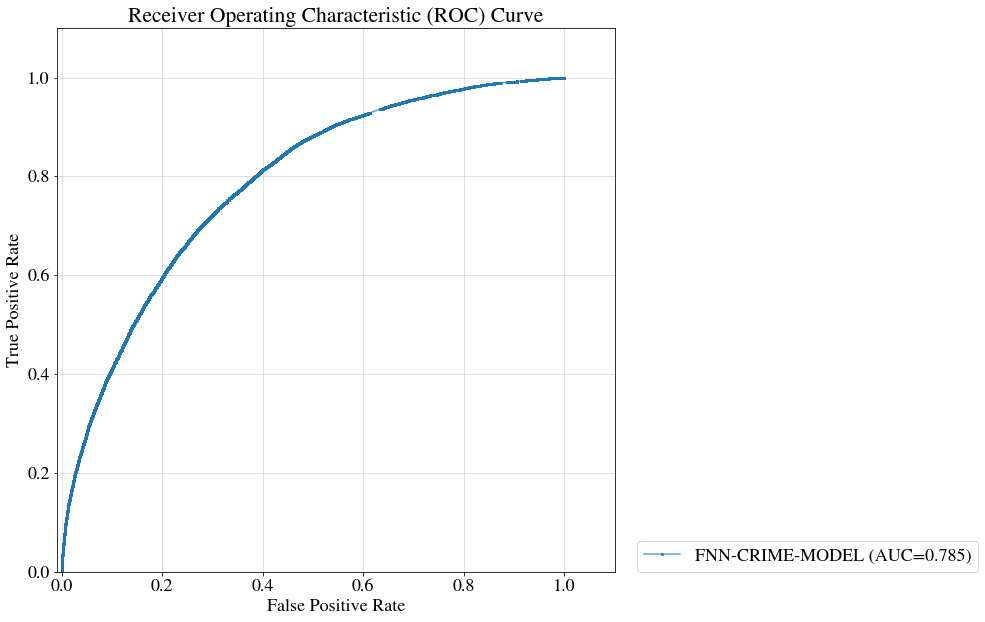

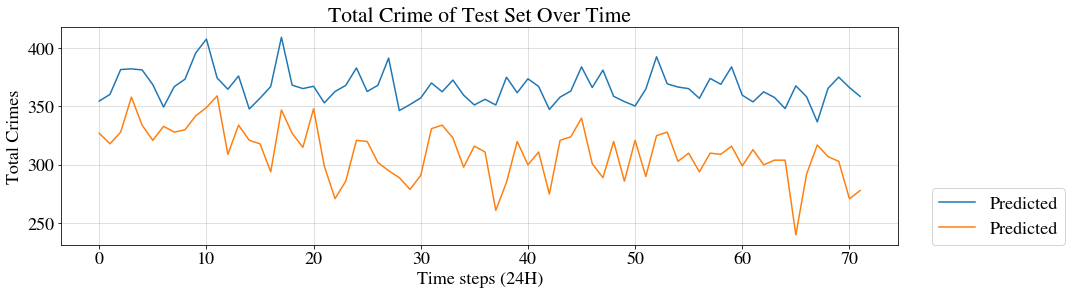

In [19]:
from utils.metrics import best_threshold

# todo make wrapper that takes eval loop which returns probas_pred
def evaluate_fnn(model, batch_loader, conf):    
    # todo not target shapes anymore because of year offset
    probas_pred = np.zeros(batch_loader.dataset.target_shape,dtype=np.float)
    y_true = batch_loader.dataset.targets[-len(probas_pred):]
    t_range = batch_loader.dataset.t_range[-len(probas_pred):]
    
    
    with torch.set_grad_enabled(False):
        model.eval()
            
        num_batches = batch_loader.num_batches
        for indices, spc_feats, tmp_feats, env_feats, targets in batch_loader:
            current_batch = batch_loader.current_batch

            # Transfer to PyTorch Tensor and GPU
            spc_feats = torch.Tensor(spc_feats[0]).to(conf.device) # only taking [0] for fnn
            tmp_feats = torch.Tensor(tmp_feats[0]).to(conf.device) # only taking [0] for fnn
            env_feats = torch.Tensor(env_feats[0]).to(conf.device) # only taking [0] for fnn
            targets = torch.LongTensor(targets[0,:,0]).to(conf.device) # only taking [0] for fnn
            out = model(spc_feats, tmp_feats, env_feats)

            batch_probas_pred = F.softmax(out,dim=-1)[:,1].numpy() # select class1 prediction
            
            for i, p in zip(indices,batch_probas_pred):
                n,c,l = i   
                probas_pred[n,c,l] = p

    y_pred = np.copy(probas_pred)
    thresh = best_threshold(y_true, probas_pred)
    y_pred[y_pred >= thresh] = 1
    y_pred[y_pred < thresh] = 0
    
    return y_true, y_pred, probas_pred, t_range


def save_metrics(y_true, y_pred, probas_pred, t_range, shaper, conf):
    """
    Training the model for a single epoch
    """
    # save result
    # only saves the result of the metrics not the predicted values
    model_metrics = ModelMetrics(model_name=conf.model_name,
                                 y_true=y_true,
                                 y_pred=y_pred,
                                 probas_pred=probas_pred)
    log.info(model_metrics)

    # saves the actual target and predicted values to be visualised later on
    model_result = ModelResult(model_name=conf.model_name,
                               y_true=y_true,
                               y_pred=y_pred,
                               probas_pred=probas_pred,
                               t_range=t_range,
                               shaper=shaper)
    log.info(model_result)

    # do result plotting and saving
    pr_plotter = PRCurvePlotter()
    pr_plotter.add_curve(y_true.flatten(), probas_pred.flatten(), label_name=conf.model_name)
    pr_plotter.savefig(f"{conf.model_path}plot_pr_curve.png")

    roc_plotter = ROCCurvePlotter()
    roc_plotter.add_curve(y_true.flatten(), probas_pred.flatten(), label_name=conf.model_name)
    roc_plotter.savefig(f"{conf.model_path}plot_roc_curve.png")
        
    total_crime_plot = PerTimeStepPlotter(time_step=t_range.freqstr,ylabel="Total Crimes")
    total_crime_plot.plot(probas_pred.sum(-1)[:,0],label="Predicted")
    total_crime_plot.plot(y_true.sum(-1)[:,0],label="Predicted")
    total_crime_plot.savefig(f"{conf.model_path}plot_total_crimes.png")
    
    
y_true, y_pred, probas_pred, t_range = evaluate_fnn(model=model,
                                                    batch_loader=loaders.test_loader,
                                                    conf=conf)    
    
save_metrics(y_true=y_true,
             y_pred=y_pred,
             probas_pred=probas_pred,
             t_range=t_range,
             shaper=None,#data_group.shaper,                
             conf=conf)    

In [ ]:
import matplotlib.pyplot as plt

In [52]:
from utils.metrics import BaseMetricPlotter

In [74]:
class PerTimeStepPlotter(BaseMetricPlotter):
    """
    Plot time related things
    """

    # setup maybe add the size of the figure
    def __init__(self, time_step,ylabel,title="Total Crime of Test Set Over Time"):
        super(PerTimeStepPlotter, self).__init__(title)
        
        plt.figure(figsize=(15,4))

        plt.ylabel(ylabel)
        plt.xlabel(f"Time steps ({time_step})")

    @staticmethod        
    def setup():
        print("setup - done")

    @staticmethod
    def plot(data,label):
        plt.plot(data,label=label)

setup - done


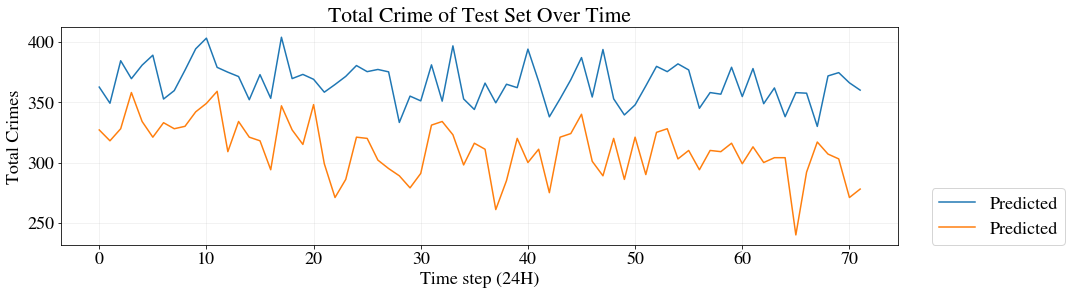

In [75]:
total_crime_plot = PerTimeStepPlotter(time_step=str(data_group.t_range.freqstr),ylabel="Total Crimes")
total_crime_plot.plot(probas_pred.sum(-1)[:,0][:lim],label="Predicted")
total_crime_plot.plot(y_true.sum(-1)[:,0][:lim],label="Predicted")
total_crime_plot.show()


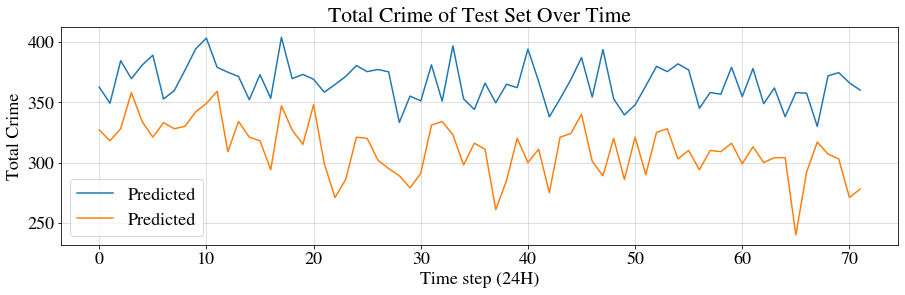

In [78]:
plt.figure(figsize=(15,4))
plt.title("Total Crime of Test Set Over Time")
plt.ylabel("Total Crime")
plt.xlabel(f"Time step ({str(data_group.t_range.freqstr)})")
plt.grid(True, alpha=0.5)
plt.plot(probas_pred.sum(-1)[:,0][:lim],label="Predicted")
plt.plot(y_true.sum(-1)[:,0][:lim],label="Predicted")
plt.legend()
plt.show()

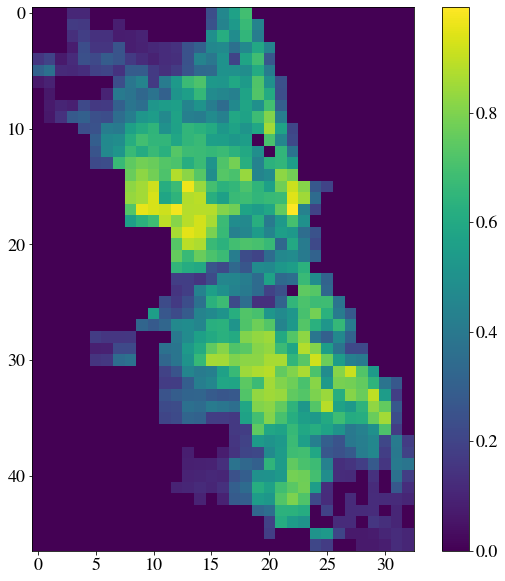

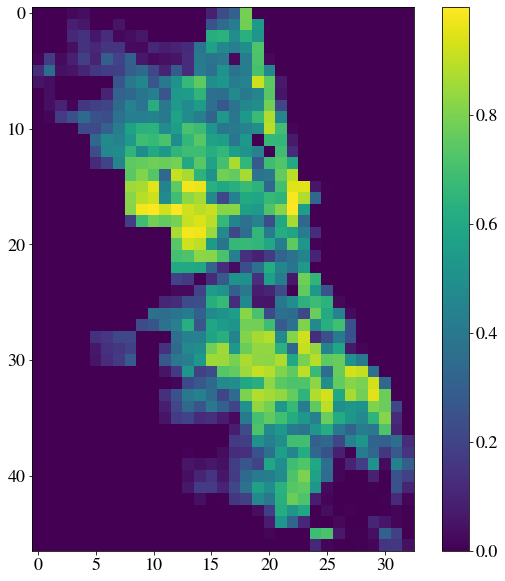

In [40]:
im(data_group.shaper.unsqueeze(probas_pred).mean(0)[0])
im(data_group.shaper.unsqueeze(data_group.targets).mean(0)[0])

In [ ]:
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

In [ ]:
roc_auc_score()

In [ ]:
def average_precision_score_per_cell(y_true, probas_pred):
    """
    y_true: shape (N,1,L)
    probas_pred: (N,1,L)
    """
    N,_,L = y_true.shape
    result = np.zeros(L)
    
    for i in range(L):
        result[i] = average_precision_score(y_true=y_true[:,:,i].flatten()
                                            , y_score=probas_pred[:,:,i].flatten())
        
    return result

def roc_auc_score_per_cell(y_true, probas_pred):
    """
    y_true: shape (N,1,L)
    probas_pred: (N,1,L)
    """
    N,_,L = y_true.shape
    result = np.zeros(L)
    
    for i in range(L):
        result[i] = average_precision_score(y_true=y_true[:,:,i].flatten(),
                                            y_score=probas_pred[:,:,i].flatten())
        
    return result
    
    
def average_precision_score_per_time_slot(y_true, probas_pred):
    """
    y_true: shape (N,1,L)
    probas_pred: (N,1,L)
    """
    N,_,L = y_true.shape
    result = np.zeros(N)
    
    for i in range(N):
        result[i] = average_precision_score(y_true=y_true[:,:,i].flatten(),
                                            y_score=probas_pred[:,:,i].flatten())
        
    return result

def roc_auc_score_per_time_slot(y_true, probas_pred):
    """
    y_true: shape (N,1,L)
    probas_pred: (N,1,L)
    """
    N,_,L = y_true.shape
    result = np.zeros(N)
    
    for i in range(N):
        result[i] = average_precision_score(y_true=y_true[i,:,:].flatten(),
                                            y_score=probas_pred[i,:,:].flatten())
        
    return result    
    

# metric_per_time_step - get the auc or ap 

In [ ]:
im(data_group.shaper.unsqueeze(probas_pred)[40][0])
im(data_group.shaper.unsqueeze(loaders.test_loader.dataset.targets)[40][0])

In [ ]:
loaders.test_loader.dataset.targets.shape

# Todo Evaluation prediction formating into an actual map

In [ ]:
targets = loaders.data_group.testing_set.targets

# todo get better name
probas_grid = np.zeros_like(targets)

In [ ]:

###### testing ###### torch outputs to see if we're actually getting valuable things out
out = torch.Tensor([[-3,2],[2,-1],[0.5,0.4]])
print(out.shape)
print(out)
out_soft = F.softmax(out, dim=-1)
print(out_soft)
out_label = torch.argmax(out_soft, dim=-1)
print(out_label)



In [ ]:
model.load_state_dict(torch.load(model_path + "model_best.pth"))
conf = BaseConf(conf_dict=conf_dict)
conf.batch_size = 4
loaders = FlatDataLoaders(data_path=data_path, conf=conf)

# EVALUATE MODEL
with torch.set_grad_enabled(False):
    # Transfer to GPU
    testing_losses = []
    y_true = []
    y_pred = []
    probas_pred = []
    
    
    # loop through is set does not fit in batch
    for indices, spc_feats, tmp_feats, env_feats, targets in loaders.test_loader: 
        """
        IMPORTNANT NOTE: WHEN DOING LSTM - ONLY FEED THE TEMPORAL VECTORS IN THE LSTM
        FEED THE REST INTO THE NORMAL LINEAR NETWORKS
        """
        
        
        # Transfer to GPU
        spc_feats = torch.Tensor(spc_feats).to(conf.device)
        tmp_feats = torch.Tensor(tmp_feats).to(conf.device)
        env_feats = torch.Tensor(env_feats).to(conf.device)
        targets = torch.LongTensor(targets).to(conf.device)
        
        y_true.extend(targets.tolist())
        out = model(spc_feats, tmp_feats, env_feats)
                        
        out = F.softmax(out, dim=-1)
        
        log.info(f"out: {out}")
        log.info(f"indices: {indices}")
        log.info(f"indices: {targets}")
    
        out_label = torch.argmax(out, dim=-1)
        log.info(f"out_label: {out_label}")
        y_pred.extend(out_label.tolist())
        out_proba = out[:, 1]  # likelihood of crime is more general form - when comparing to moving averages
        probas_pred.extend(out_proba.tolist())
        
        break  # !! remove


# todo change to be the shape (N,L) of the original prediction.        
model_result = ModelResult(model_name="FNN (Kang and Kang)",
                            y_true=y_true,
                            y_pred=y_pred,
                            probas_pred=probas_pred,
                            t_range=loaders.test_loader.dataset.t_range,
                            shaper=loaders.data_group.shaper)
                        
# log.info(model_result)

np.savez_compressed(model_path + "evaluation_results.npz", model_result)

In [ ]:
pr_plotter = PRCurvePlotter()
pr_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
pr_plotter.savefig(model_path + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
roc_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
roc_plotter.savefig(model_path + "plot_roc_curve.png")

info["stop_time"] = strftime("%Y-%m-%dT%H:%M:%S")
write_json(info, model_path + "info.json")

log.info("=====================================END=====================================")targets.shape